In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def parser(date_string):
    date_object = datetime.strptime(date_string, "%Y-%m-%d")
    return date_object.strftime("%Y-%m")

def check_stationarity(series):   
    """
    Check stationarity using ADF test
    Ho : The series is non-stationary and has a unit root --> p-value > 0.05
    H1 : The series is stationary and does not have a unit root --> p-value < 0.05
    """
   
    X = series.values
    result = adfuller(X)
    print('Test: Running ADF Stationarity test for {} \n\t ADF test statistic: {} \n\t p-value: {} '.format(series.name, result[0], result[1]))

    print('\n\tCritical Values:')
    for key, value in result[4].items():
    	print('\t%s: %.3f' % (key, value))
    
    if result[4]['5%'] > result[0]:
        conclusion = 'Series is Stationary @95% CI'
        print ('\t Conclusion: Series is stationary at 95% CI\n')
    elif result[4]['10%'] > result[0]:
        conclusion = 'Series is Stationary @90% CI'
        print ('\t Conclusion: Series is stationary at 90% CI but non-stationary at 95% CI\n')
    else:
        conclusion = 'Series is non-Stationary'
        print ('\t Conclusion: Series is non-stationary\n')
    return conclusion


def remove_seasonality(series):
    """
    Remove seasonality from a time series by subtracting the monthly averages.

    Args:
        series (pd.Series): The time series data.

    Returns:
        pd.Series: The time series with seasonality removed.
    """
    # Calculate the monthly averages
    month_avgs = series.groupby(series.index.month).mean()

    # Create a series of monthly averages with the same index as the original series
    month_avg_series = series.index.to_series().map(lambda d: month_avgs.loc[d.month])

    # Subtract the monthly averages from the original series
    deseasonalized_series = series - month_avg_series

    return deseasonalized_series

def remove_increasing_vola(series):
    annual_volatility = series.groupby(series.index.year).std()
    series_annual_volatility = series.index.map(lambda d: annual_volatility.loc[d.year])
    series = series / series_annual_volatility
    return series


def series_standardization(series) -> pd.Series:
    avg, dev = series.mean(), series.std()
    standardized_series = (series - avg) / dev
    return standardized_series

from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [3]:
df = pd.read_csv("./assets/Daten.csv",sep=";" , parse_dates=[0], index_col=0, date_parser=parser).squeeze()
df = df.asfreq(pd.infer_freq(df.index))
df

C:\Users\joshi\AppData\Local\Temp\ipykernel_2892\2250414381.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("./assets/Daten.csv",sep=";" , parse_dates=[0], index_col=0, date_parser=parser).squeeze()


,VSTOXX,VIX,VDAX,Ifo,DE_EPU,Glob_EPU
Datum,,,,,,
2000-01-01,"28,94837619","23,202","31,4","96,2","73,23399039","63,36971598"
2000-02-01,"30,04859048","23,5955","28,54","97,8","97,3584286","58,69227896"
2000-03-01,"28,53686522","22,71826087","26,84",97,"96,09150486","60,83247665"
2000-04-01,"28,53848333","27,16421053","23,7","98,2","69,44795177","64,23391535"
2000-05-01,"27,94932727","26,37318182","23,67","98,3","135,287133","86,54617843"
...,...,...,...,...,...,...
2023-11-01,"15,16474545","14,01909091","14,52727273","86,4","626,1370391","246,8767661"
2023-12-01,"13,40822632","12,7185","13,35421053","84,9","672,5178656","255,8841805"
2024-01-01,"14,08706364","13,38863636","13,86409091","84,6","729,8969081","229,2457779"


In [4]:
# Fehlende Wert Nan rows
df = df.dropna()
#change , to .
df = df.replace({',': '.'}, regex=True)
df = df[df.index.year != 2024]
# fromat all values to float
df = df.astype(float)
df

,VSTOXX,VIX,VDAX,Ifo,DE_EPU,Glob_EPU
Datum,,,,,,
2000-01-01,28.948376,23.202000,31.400000,96.2,73.233990,63.369716
2000-02-01,30.048590,23.595500,28.540000,97.8,97.358429,58.692279
2000-03-01,28.536865,22.718261,26.840000,97.0,96.091505,60.832477
2000-04-01,28.538483,27.164211,23.700000,98.2,69.447952,64.233915
2000-05-01,27.949327,26.373182,23.670000,98.3,135.287133,86.546178
...,...,...,...,...,...,...
2023-08-01,18.548770,15.853913,17.449130,85.7,661.260914,211.125818
2023-09-01,16.870852,15.173333,15.719048,85.7,737.681932,243.886101
2023-10-01,20.232068,18.887727,19.102727,85.5,669.565170,226.105660


In [5]:
#### check if series
print(df.VSTOXX)
type(df.VSTOXX)

Datum
2000-01-01    28.948376
2000-02-01    30.048590
2000-03-01    28.536865
2000-04-01    28.538483
2000-05-01    27.949327
                ...    
2023-08-01    18.548770
2023-09-01    16.870852
2023-10-01    20.232068
2023-11-01    15.164745
2023-12-01    13.408226
Freq: MS, Name: VSTOXX, Length: 288, dtype: float64


pandas.core.series.Series

In [6]:
series_vstoxx = df.VSTOXX
series_vix = df.VIX
series_vdax = df.VDAX
series_ifo = df.Ifo
series_de_epu = df.DE_EPU
series_glob_epu = df.Glob_EPU

series_vstoxx = series_vstoxx.astype(float)
series_vix = series_vix.astype(float)
series_vdax = series_vdax.astype(float)
series_ifo = series_ifo.astype(float)
series_de_epu = series_de_epu.astype(float)
series_glob_epu = series_glob_epu.astype(float)
series_vstoxx[0]

C:\Users\joshi\AppData\Local\Temp\ipykernel_2892\2096824242.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  series_vstoxx[0]


28.94837619

### Granger Causality Test

In [7]:
grangers_causation_matrix(df, variables = df.columns)

c:\Users\joshi\workspace\BA-VAR\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\joshi\workspace\BA-VAR\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\joshi\workspace\BA-VAR\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\joshi\workspace\BA-VAR\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\joshi\workspace\BA-VAR\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\joshi\workspace\BA-VAR\venv\Lib\site-packages\statsmodels\tsa\stat

,VSTOXX_x,VIX_x,VDAX_x,Ifo_x,DE_EPU_x,Glob_EPU_x
VSTOXX_y,1.0000,0.0536,0.1445,0.2700,0.1672,0.0035
VIX_y,0.1454,1.0000,0.0492,0.1916,0.4619,0.0410
VDAX_y,0.0950,0.0633,1.0000,0.2983,0.3256,0.0058
Ifo_y,0.0000,0.0000,0.0000,1.0000,0.0566,0.3151
DE_EPU_y,0.0020,0.0446,0.0022,0.0003,1.0000,0.0379
Glob_EPU_y,0.0002,0.0002,0.0001,0.0000,0.0032,1.0000


In [8]:
series_vstoxx = series_vstoxx.astype(float)
series_vix = series_vix.astype(float)
series_vdax = series_vdax.astype(float)
series_ifo = series_ifo.astype(float)
series_de_epu = series_de_epu.astype(float)
series_glob_epu = series_glob_epu.astype(float)

In [9]:
check_stationarity(series=series_vstoxx)
check_stationarity(series=series_vix)
check_stationarity(series=series_de_epu)
check_stationarity(series=series_vdax)
check_stationarity(series=series_glob_epu)
check_stationarity(series=series_ifo)

Test: Running ADF Stationarity test for VSTOXX 
	 ADF test statistic: -3.7085921688140724 
	 p-value: 0.0039939080274051676 

	Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is stationary at 95% CI

Test: Running ADF Stationarity test for VIX 
	 ADF test statistic: -4.304555397145242 
	 p-value: 0.000436212501729611 

	Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is stationary at 95% CI

Test: Running ADF Stationarity test for DE_EPU 
	 ADF test statistic: -1.065469559022073 
	 p-value: 0.7286440416712561 

	Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is non-stationary

Test: Running ADF Stationarity test for VDAX 
	 ADF test statistic: -4.769348929168181 
	 p-value: 6.222442676861572e-05 

	Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is stationary at 95% CI

Test: Running ADF Stationarity test for Glob_EPU 
	 ADF test statistic: -0.6922793697606332 
	 p-value: 0.8487

'Series is Stationary @95% CI'

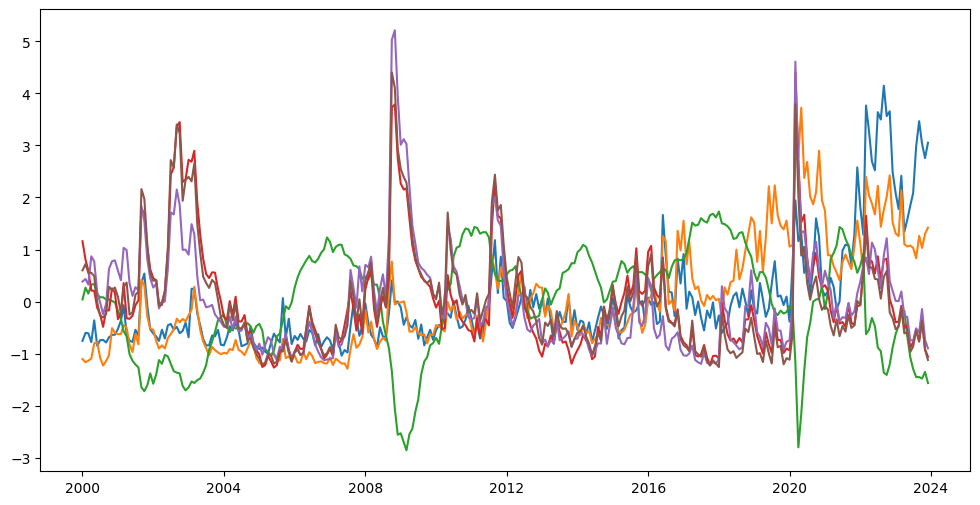

In [10]:
# Normalisieren aller zeitreihen
series_de_epu_norm = series_standardization(series=series_de_epu)
series_global_epu_norm = series_standardization(series=series_glob_epu)
series_ifo_norm = series_standardization(series=series_ifo)
series_vdax_norm = series_standardization(series=series_vdax)
series_vix_norm = series_standardization(series=series_vix)
series_vstoxx_norm = series_standardization(series=series_vstoxx)


plt.figure(figsize=(12,6))
plt.plot(series_de_epu_norm)
plt.plot(series_global_epu_norm)
plt.plot(series_ifo_norm)
plt.plot(series_vdax_norm)
plt.plot(series_vix_norm)
plt.plot(series_vstoxx_norm)

# Trendkorrekturen

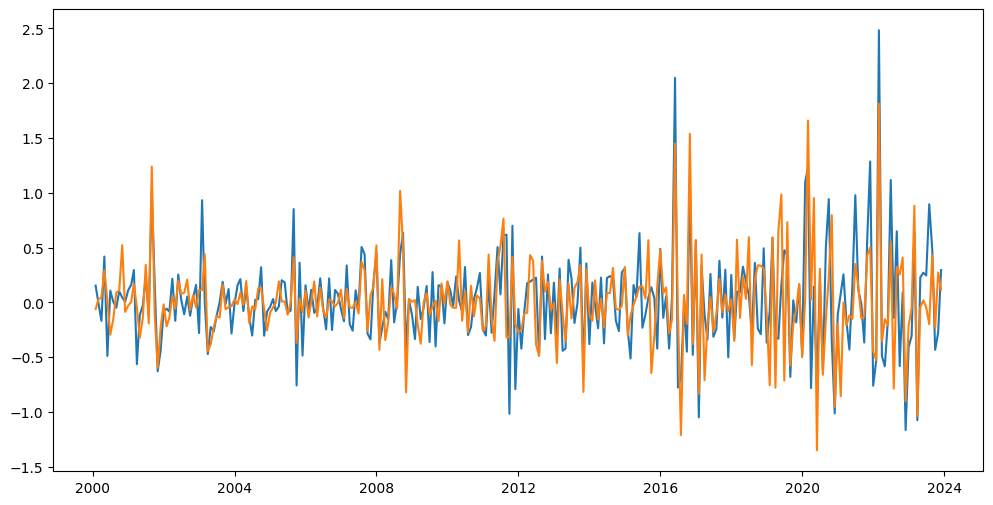

In [11]:
# differences of the Series elements (default is element in previous row)
series_de_epu_norm_trendremoved = series_de_epu_norm.diff()
series_global_epu_norm_trendremoved = series_global_epu_norm.diff()

plt.figure(figsize=(12,6))
plt.plot(series_de_epu_norm_trendremoved)
plt.plot(series_global_epu_norm_trendremoved)



# Korrektur Ansteigende Volatilität

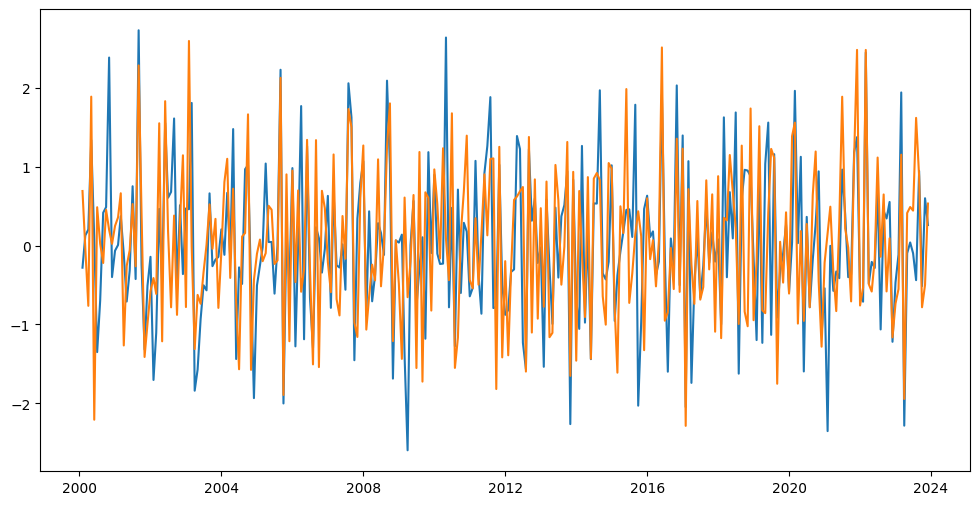

In [12]:
series_global_epu_norm_trendremoved = remove_increasing_vola(series_global_epu_norm_trendremoved)
series_de_epu_norm_trendremoved = remove_increasing_vola(series_de_epu_norm_trendremoved)

plt.figure(figsize=(12,6))
plt.plot(series_global_epu_norm_trendremoved)
plt.plot(series_de_epu_norm_trendremoved)



## Remove Seasonality

In [13]:
series_de_epu_norm_trendremoved_seas = remove_seasonality(series=series_de_epu_norm_trendremoved)
series_global_epu_norm_trendremoved_seas = remove_seasonality(series=series_global_epu_norm_trendremoved)


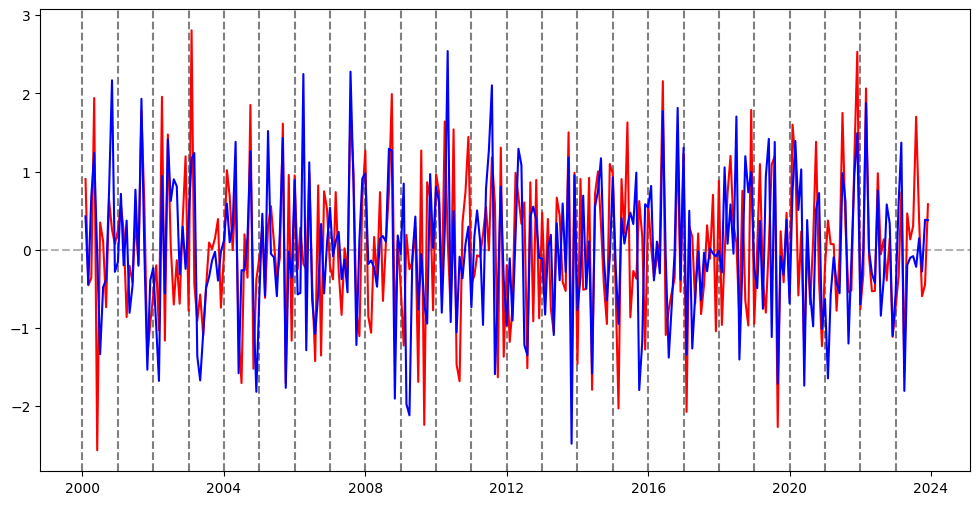

In [14]:
plt.figure(figsize=(12,6))
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
for year in range(2000, 2024):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
plt.plot(series_de_epu_norm_trendremoved_seas, color="red")
plt.plot(series_global_epu_norm_trendremoved_seas, color="blue")

## Dickey Fuller Test (check stationarity again)

In [15]:
check_stationarity(series=series_vstoxx)
check_stationarity(series=series_vix)
check_stationarity(series=series_vdax)
check_stationarity(series=series_ifo)
check_stationarity(series=series_global_epu_norm_trendremoved_seas.dropna())
check_stationarity(series=series_de_epu_norm_trendremoved_seas.dropna())

Test: Running ADF Stationarity test for VSTOXX 
	 ADF test statistic: -3.7085921688140724 
	 p-value: 0.0039939080274051676 

	Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is stationary at 95% CI

Test: Running ADF Stationarity test for VIX 
	 ADF test statistic: -4.304555397145242 
	 p-value: 0.000436212501729611 

	Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is stationary at 95% CI

Test: Running ADF Stationarity test for VDAX 
	 ADF test statistic: -4.769348929168181 
	 p-value: 6.222442676861572e-05 

	Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is stationary at 95% CI

Test: Running ADF Stationarity test for Ifo 
	 ADF test statistic: -3.0392105484547574 
	 p-value: 0.031391361404890315 

	Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is stationary at 95% CI

Test: Running ADF Stationarity test for None 
	 ADF test statistic: -6.792467236000335 
	 p-value: 2.345

'Series is Stationary @95% CI'

### Select the Order (P) of VAR model

In [16]:
from statsmodels.tsa.api import VAR


df = pd.DataFrame({
    'vstoxx': series_vstoxx,
    'vix': series_vix,
    'vdax': series_vdax,
    'ifo': series_ifo,
    'glob_epu': series_global_epu_norm_trendremoved_seas,
    'de_epu': series_de_epu_norm_trendremoved_seas
})

# remove dataframe NaN Rows
df = df.dropna()

model = VAR(df)

for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

x = model.select_order(3)
print(x.summary())

results = model.fit(maxlags=3, ic='aic')
irf = results.irf(12)


Lag Order = 1
AIC :  4.145562556780806
BIC :  4.682456459069036
FPE :  63.156844406990864
HQIC:  4.360765704963825 

Lag Order = 2
AIC :  3.944945279422828
BIC :  4.944573897180565
FPE :  51.69315527554088
HQIC:  4.345671517032914 

Lag Order = 3
AIC :  3.806759967907216
BIC :  5.271489063507137
FPE :  45.05846837505886
HQIC:  4.393999640312299 

Lag Order = 4
AIC :  3.907750099533551
BIC :  5.839965769662475
FPE :  49.9249369530185
HQIC:  4.682502072807797 

Lag Order = 5
AIC :  3.9920168344379547
BIC :  6.39412575356735
FPE :  54.45471325108822
HQIC:  4.955288595566795 

Lag Order = 6
AIC :  4.103131734928459
BIC :  6.977561402515973
FPE :  61.090691470102286
HQIC:  5.255939493499873 

Lag Order = 7
AIC :  4.189090995677496
BIC :  7.538289987169161
FPE :  66.93934730888405
HQIC:  5.532459787086005 

Lag Order = 8
AIC :  4.238497347111234
BIC :  8.064935568815468
FPE :  70.85080032752339
HQIC:  5.7734611373015845 

Lag Order = 9
AIC :  4.293358566298397
BIC :  8.59952751420455
FPE :  

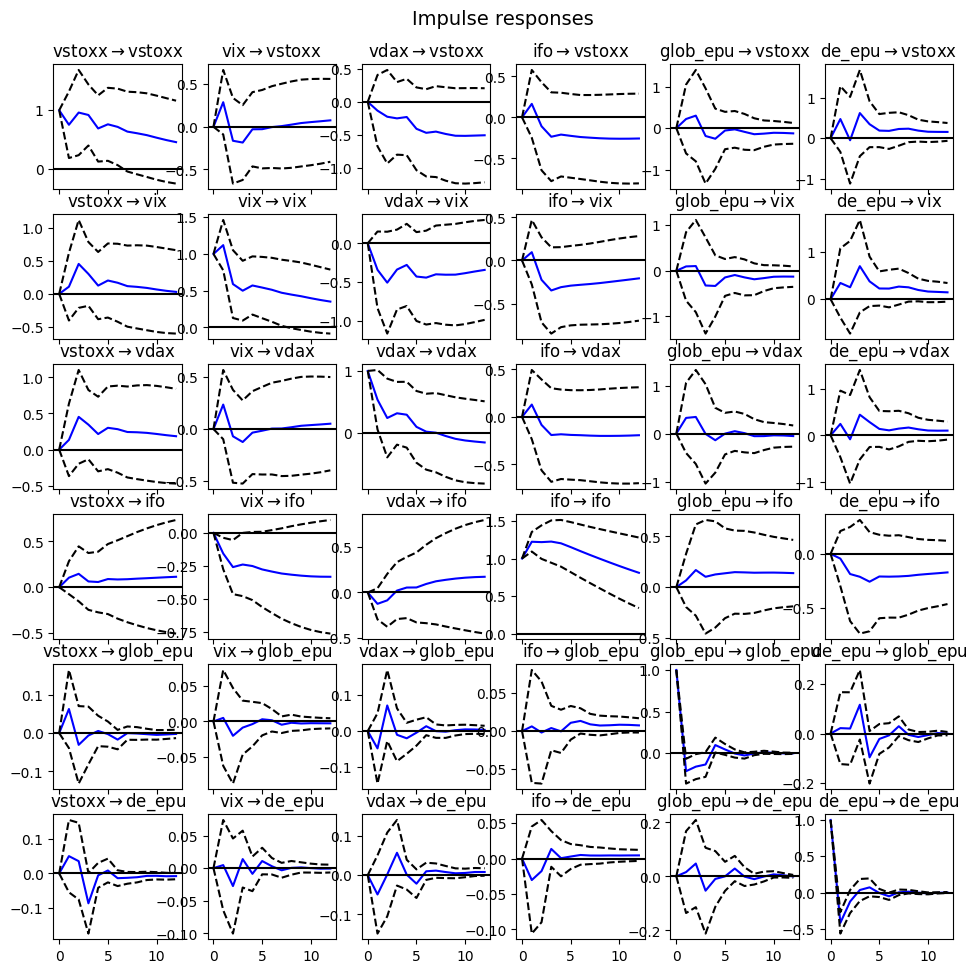

In [17]:
irf.plot(orth=False).get_figure().savefig('irf.png')

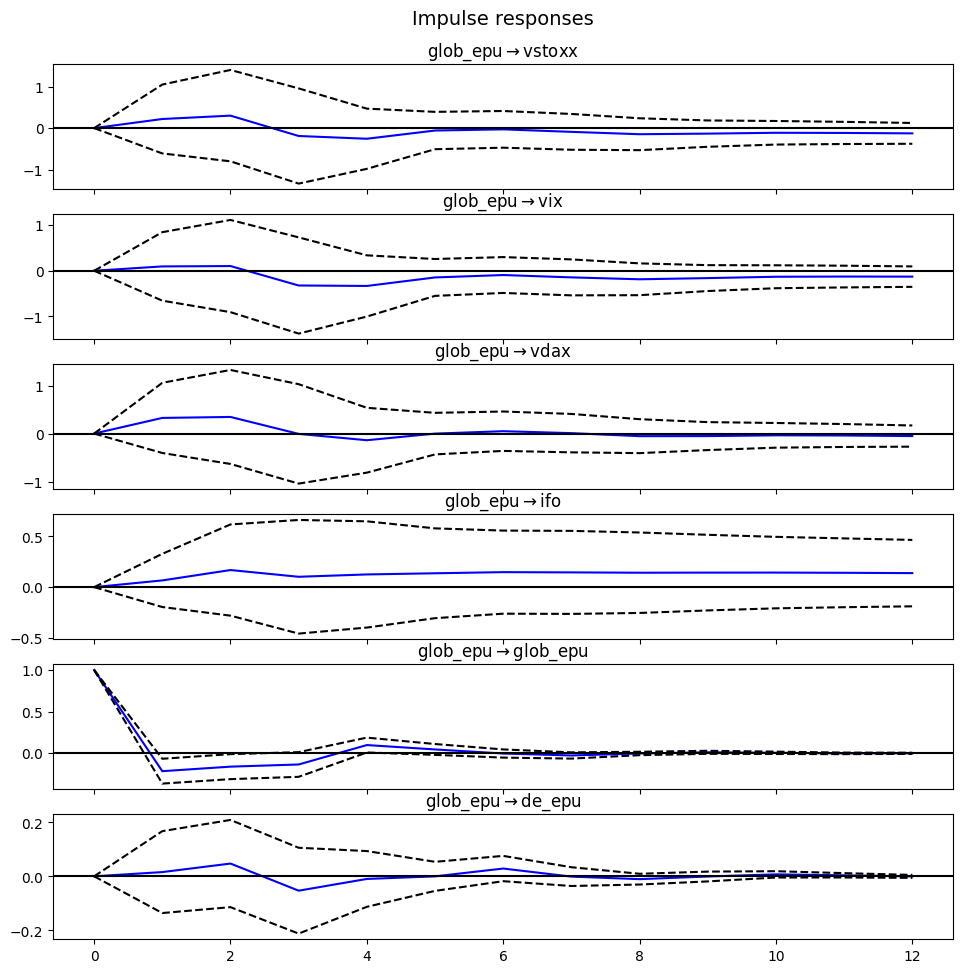

In [23]:
irf.plot(impulse='glob_epu').get_figure().savefig('glob_epu.png')

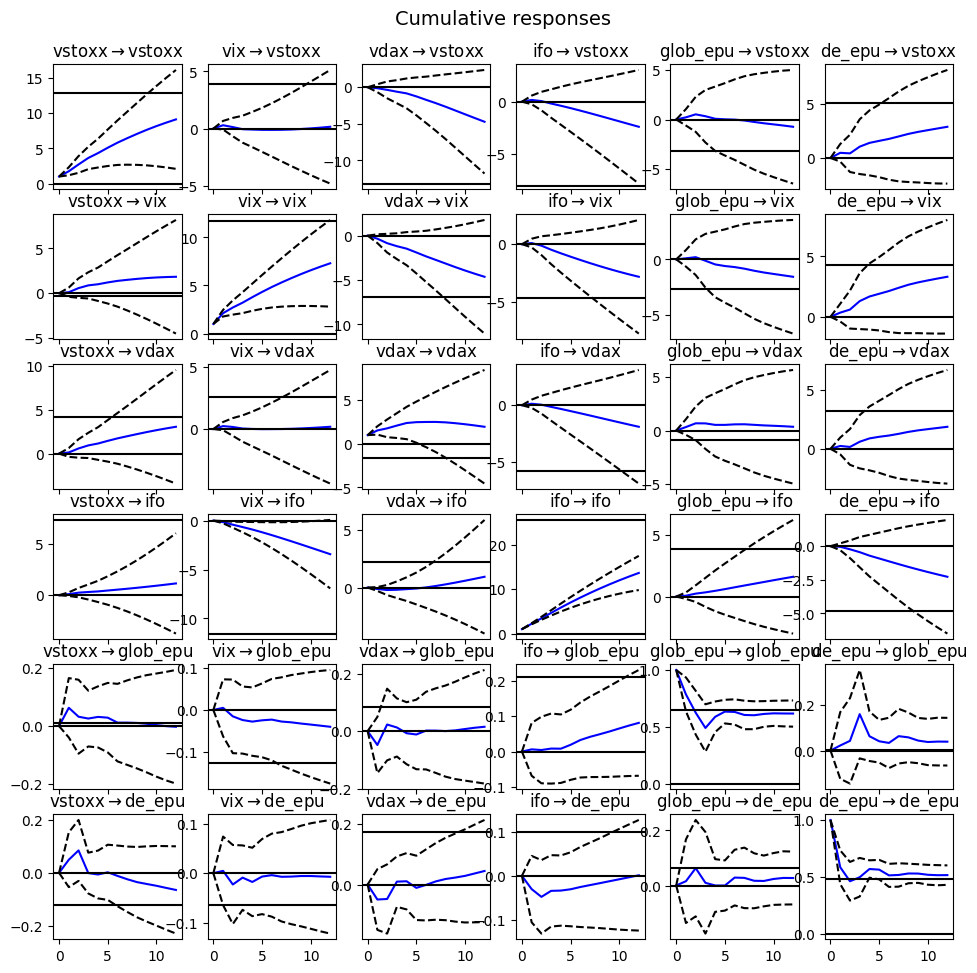

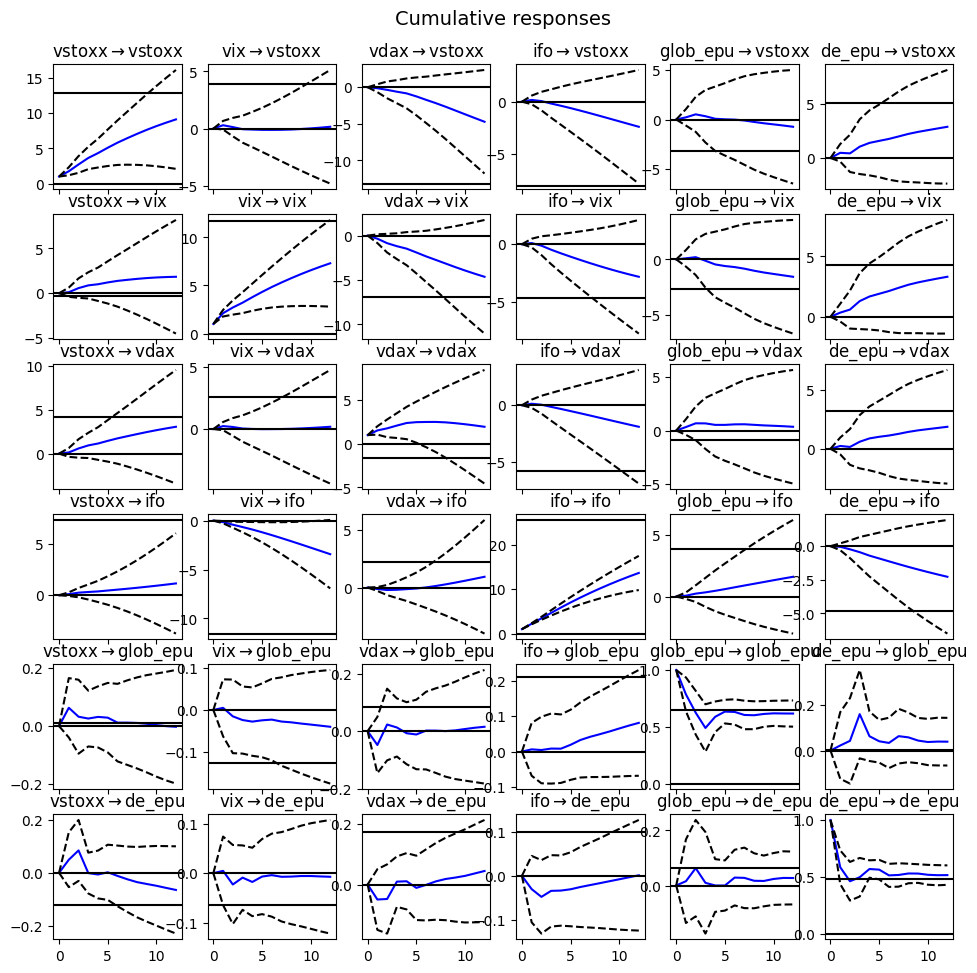

In [19]:
irf.plot_cum_effects(orth=False)

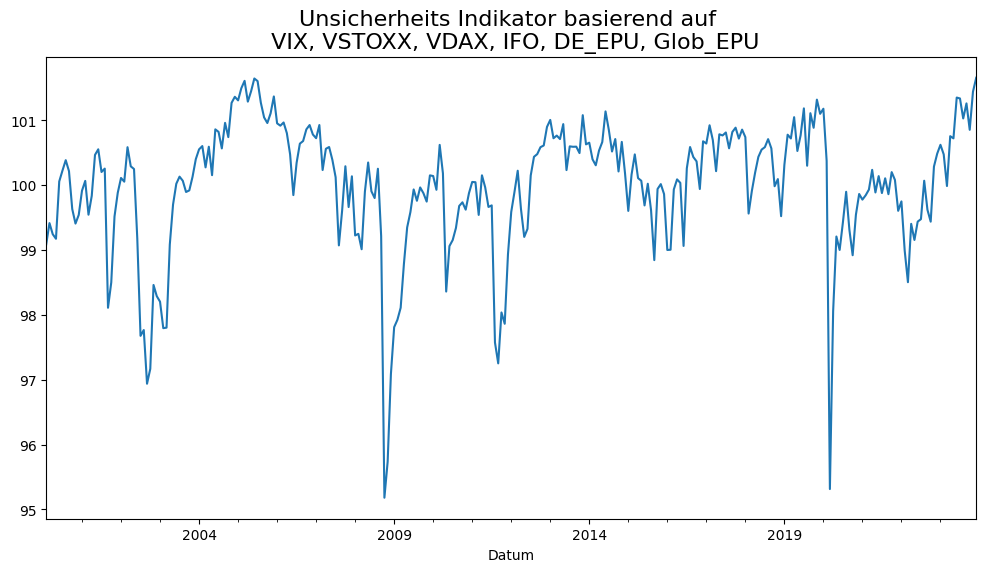

In [20]:
# Create a combined index
combined_index = df.sum(axis=1)

# Amplitude adjust the combined index
combined_index = (combined_index - combined_index.mean()) / combined_index.std()

# Set the long-term average to 100 and invert data 
# (wir haben es hier adjusted wie im Composite Leading Indicator -> Cite https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#:~:text=The%20composite%20leading%20indicator%20(CLI,qualitative%20rather%20than%20quantitative%20terms.)
combined_index = (combined_index - 100)*-1

# Plot the combined index
combined_index.plot(figsize=(12, 6))
plt.title('Unsicherheits Indikator basierend auf \n VIX, VSTOXX, VDAX, IFO, DE_EPU, Glob_EPU', fontsize=16)
plt.savefig('unsicherheits_indikator.png', bbox_inches='tight')
plt.show()



$$ {unsicherheitsIndex} = (\left(\frac{\sum_{i=1}^{n} x_i - \mu_x}{\sigma_x}\right) - 100) \times -1 $$


C:\Users\joshi\AppData\Local\Temp\ipykernel_2892\2335245424.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cli['date'] = pd.to_datetime(df_cli['date'])


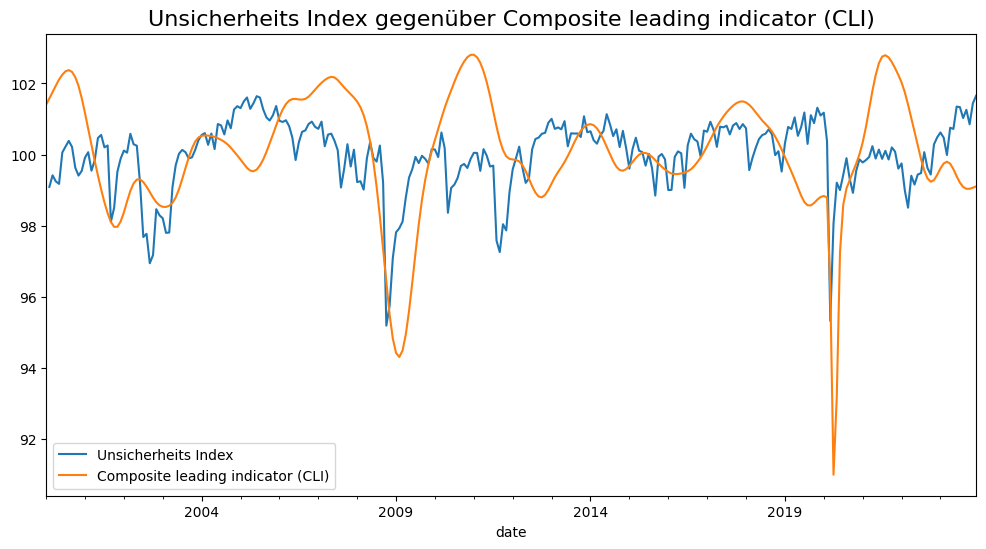

In [21]:
df_cli = pd.read_csv("./assets/cli_amplitude_adjusted.csv", sep=",", header=None)
df_cli = df_cli.rename(columns={0: 'date', 1: 'value'})
df_cli['date'] = pd.to_datetime(df_cli['date'])
df_cli['value'] = df_cli['value'].astype(float)


# Plot the combined index
combined_index.plot(figsize=(12, 6), label='Unsicherheits Index')
df_cli.plot(x='date', y='value', ax=plt.gca(), label='Composite leading indicator (CLI)')
plt.title('Unsicherheits Index gegenüber Composite leading indicator (CLI)', fontsize=16)
plt.legend()
plt.savefig('unsicherheits_indikator_vs_cli.png', bbox_inches='tight')
plt.show()

In [22]:
## unsicherheitsindikator to excel
combined_index.to_csv('unsicherheits_index.csv')